In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import helper_functions as hf
from pathlib import Path

In [2]:
root_dir = Path("Data")

tickers = ["CRWV", "FROG", "SOUN"]

# Full LOB snapshots
ticker_lob_snapshots = {
    ticker: hf.get_lob_snapshots(root_dir / ticker)
    for ticker in tickers
}

# Sampled LOB snapshots
ticker_sampled_snapshots = {
    ticker: hf.sample_snapshot(df)
    for ticker, df in ticker_lob_snapshots.items()
}

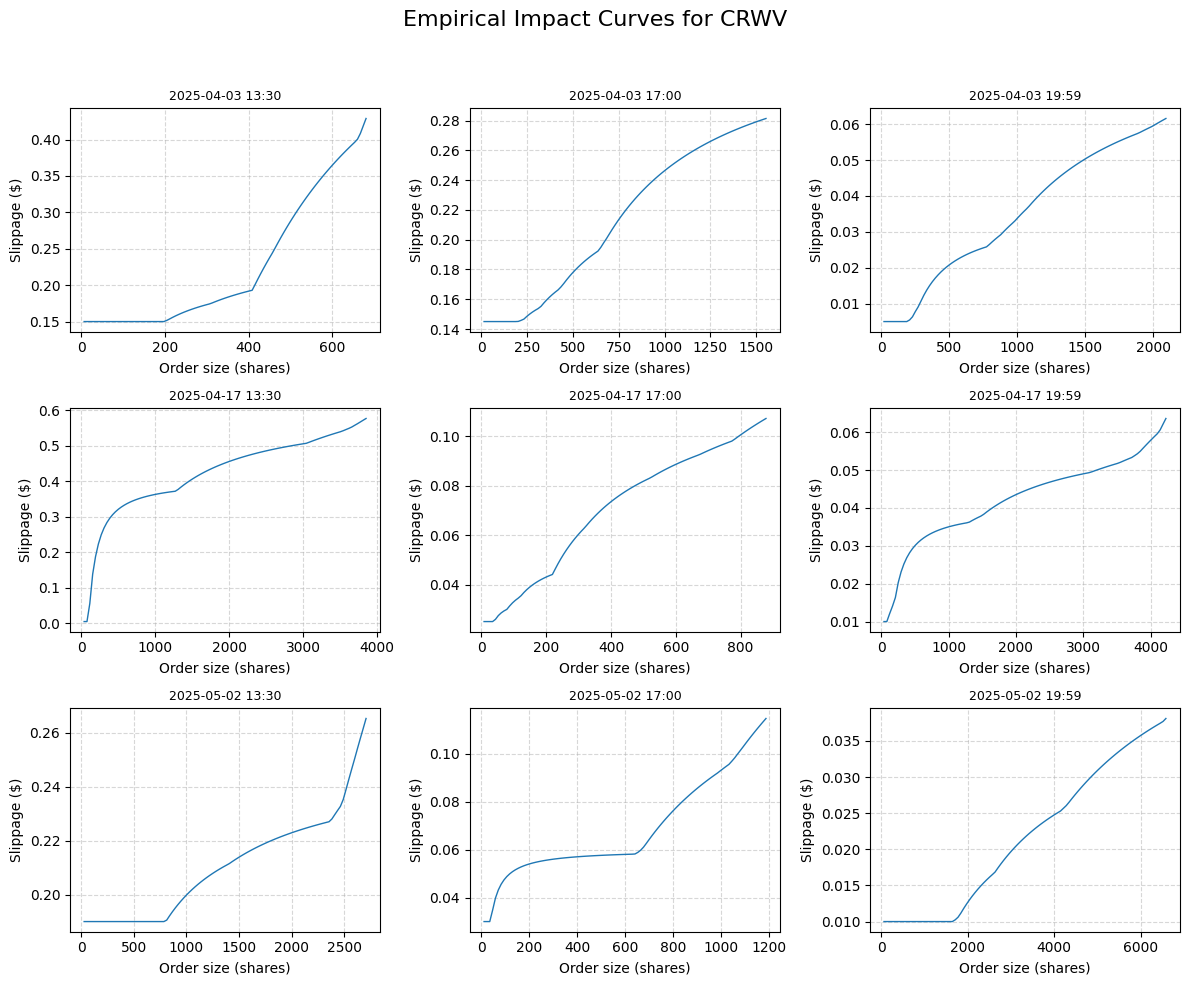

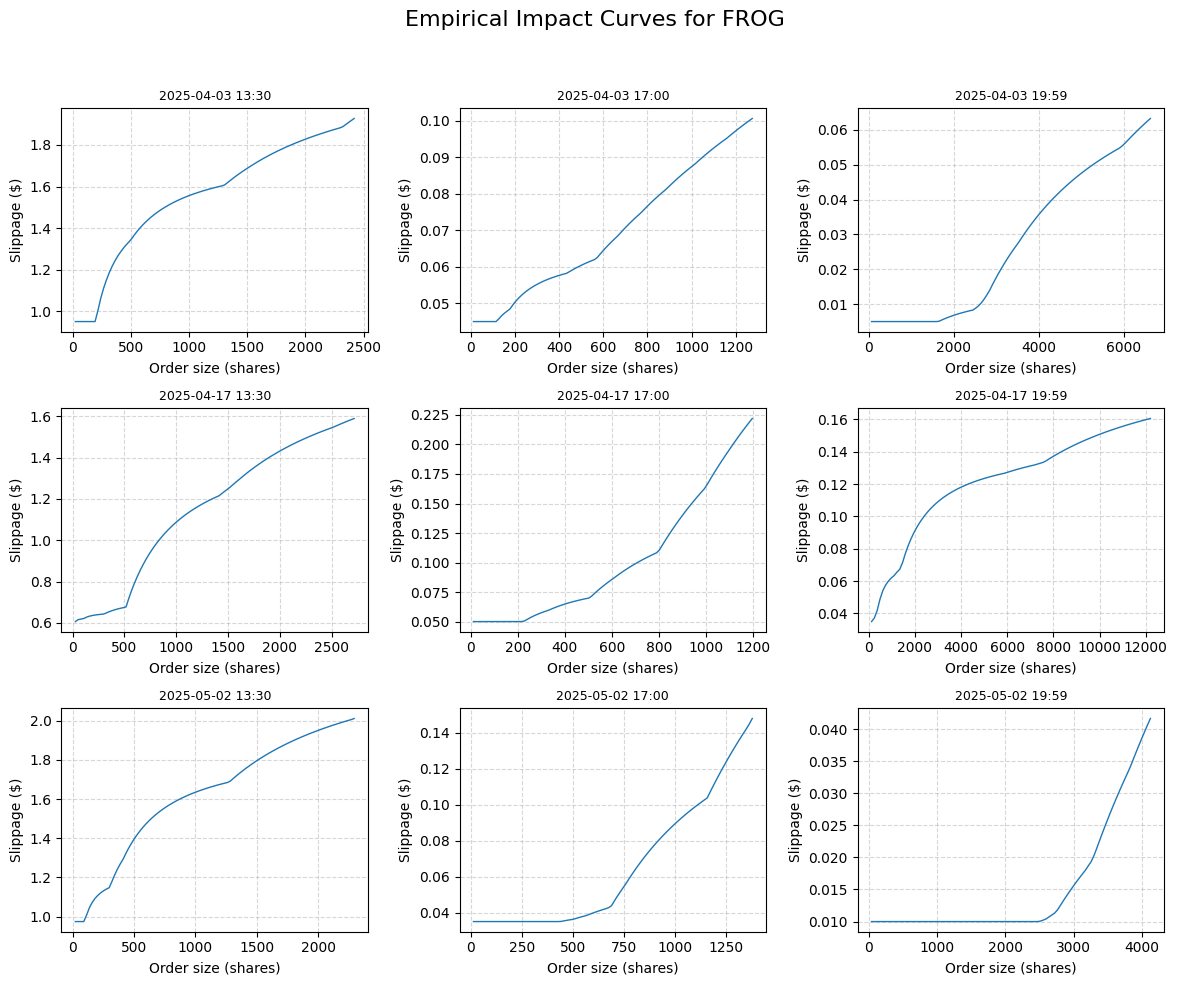

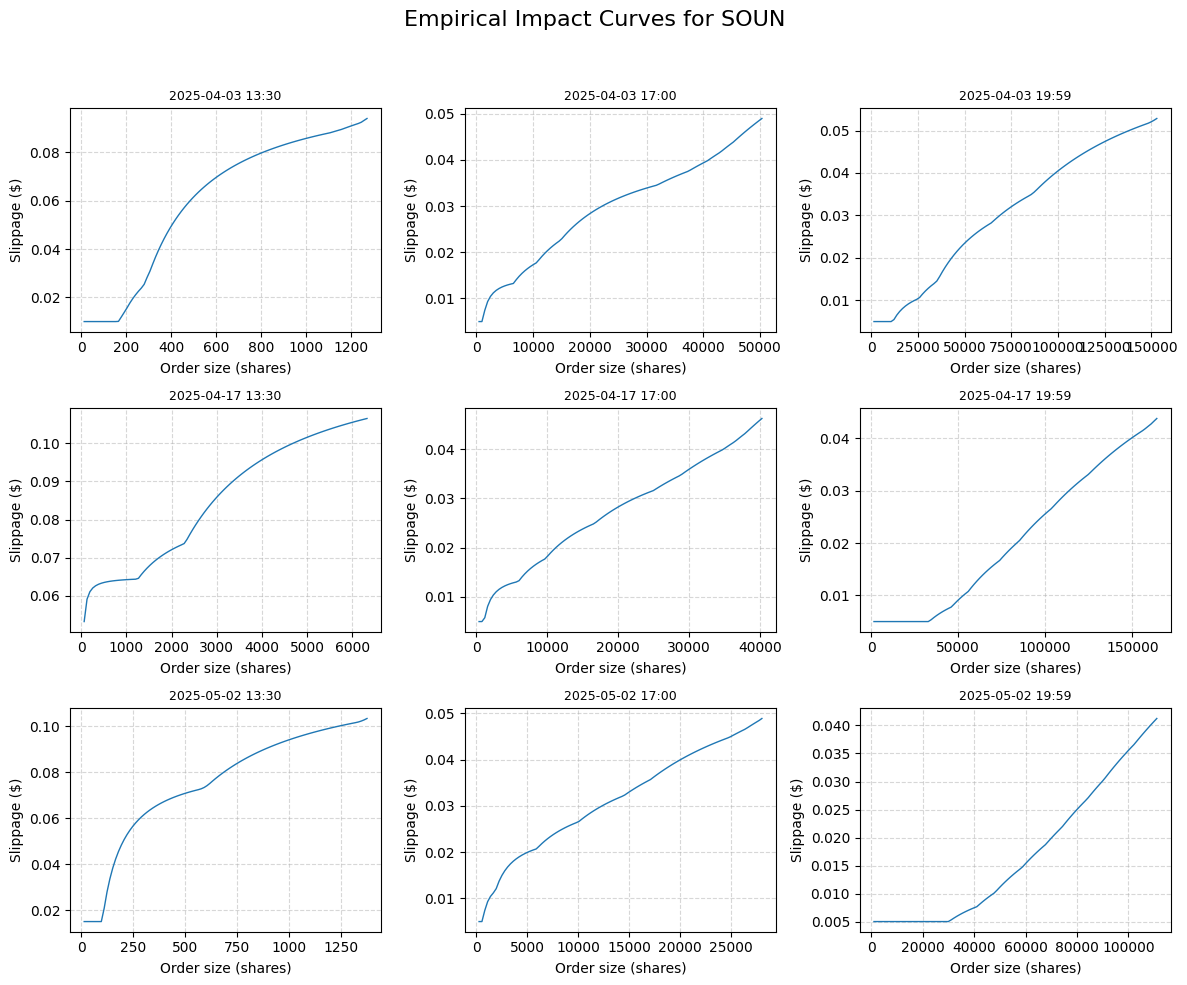

In [3]:
# Selecte days and time for plotting
samples_per_day = 14
day_indices=[0, 2, 4]
time_offsets = [0, 7, 13]

# Plot empirical impact curves for each ticker
for ticker in tickers:
    df = ticker_sampled_snapshots[ticker]
    fig, axes = plt.subplots(3, 3, figsize=(12, 10))
    fig.suptitle(f"Empirical Impact Curves for {ticker}", fontsize=16)

    for i, day in enumerate(day_indices):
        for j, offset in enumerate(time_offsets):
            row_idx = day * samples_per_day + offset

            snapshot = df.iloc[row_idx]
            x_vals, g_vals = hf.compute_empirical_impact(snapshot)

            ax = axes[i][j]
            hf.plot_impact(ax, x_vals, g_vals,
                title=f"{snapshot['ts_event'].strftime('%Y-%m-%d %H:%M')}"
            )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [4]:
fit_results = []

# Register models and their initial parameters
model_configs = {
    'linear': {'func': hf.linear_model, 'p0': [1]},
    'power_law': {'func': hf.power_law_model, 'p0': [1, 1]},
    'quadratic': {'func': hf.quadratic_model, 'p0': [1, 0]}
}

# Fit impact models to sampled snapshots
for ticker in tickers:
    df = ticker_sampled_snapshots[ticker]
    for row in df.itertuples():
        snapshot = df.iloc[row.Index]
        x_vals, g_vals = hf.compute_empirical_impact(snapshot)

        for model_name, config in model_configs.items():
            model_func = config['func']
            p0 = config['p0']

            params, mse, r2, _ = hf.fit_impact_model(x_vals, g_vals, model_func, p0)
            fit_results.append({
                'ticker': ticker,
                'ts_event': snapshot['ts_event'],
                'model': model_name,
                'params': params,
                'mse': mse,
                'r2': r2
            })

In [5]:
df_fits = pd.DataFrame(fit_results)

best_by_mse = df_fits.loc[df_fits.groupby(['ticker', 'ts_event'])['mse'].idxmin()].reset_index(drop=True)
best_model_counts_mse = best_by_mse['model'].value_counts(normalize=True).reindex(model_configs.keys(), fill_value=0)
print("Model Win Rates (by MSE):")
print(best_model_counts_mse)

best_by_r2 = df_fits.loc[df_fits.groupby(['ticker', 'ts_event'])['r2'].idxmax()].reset_index(drop=True)
best_model_counts_r2 = best_by_r2['model'].value_counts(normalize=True).reindex(model_configs.keys(), fill_value=0)
print("\nModel Win Rates (by R2):")
print(best_model_counts_r2)

Model Win Rates (by MSE):
model
linear       0.000000
power_law    0.833333
quadratic    0.166667
Name: proportion, dtype: float64

Model Win Rates (by R2):
model
linear       0.000000
power_law    0.833333
quadratic    0.166667
Name: proportion, dtype: float64


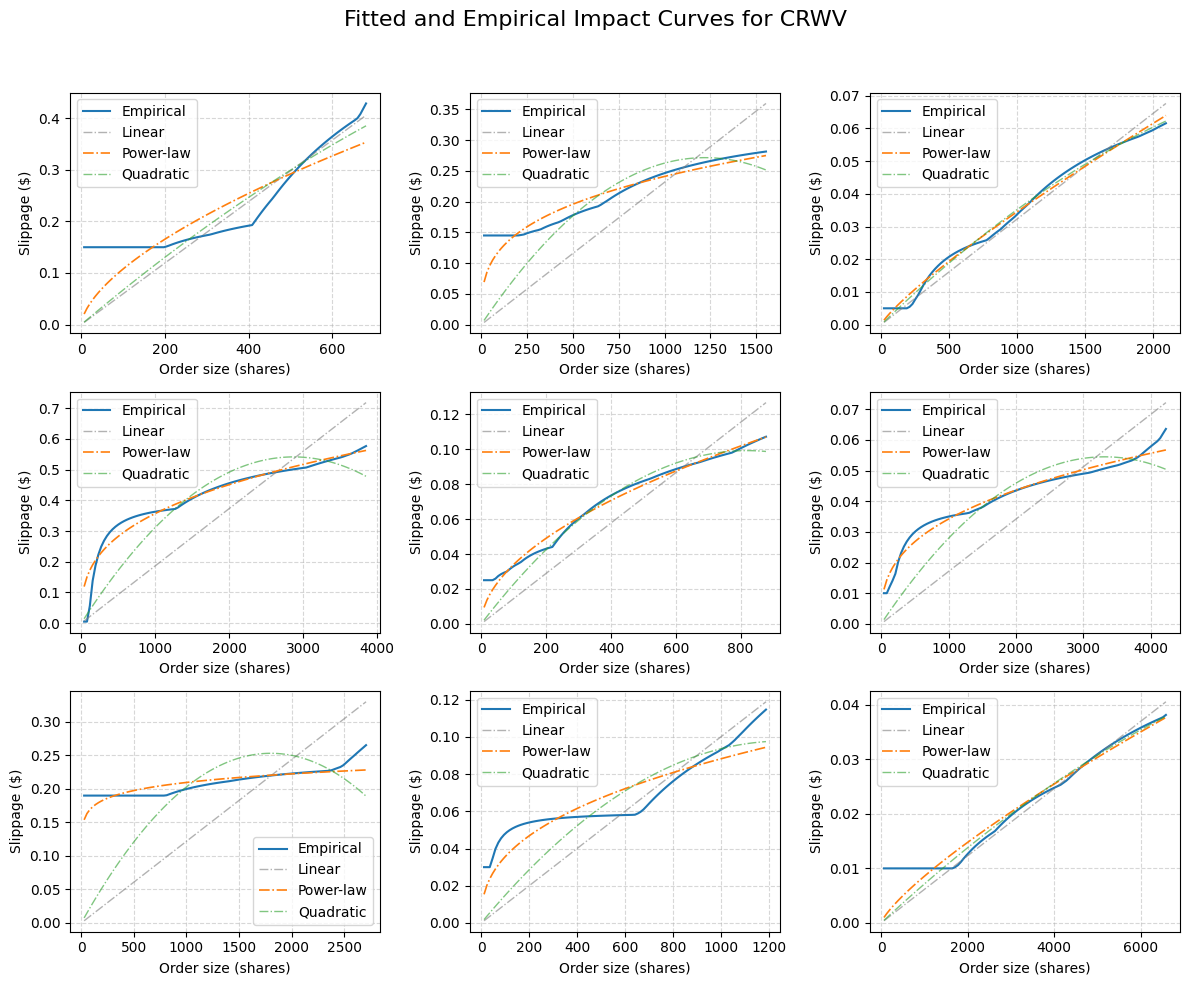

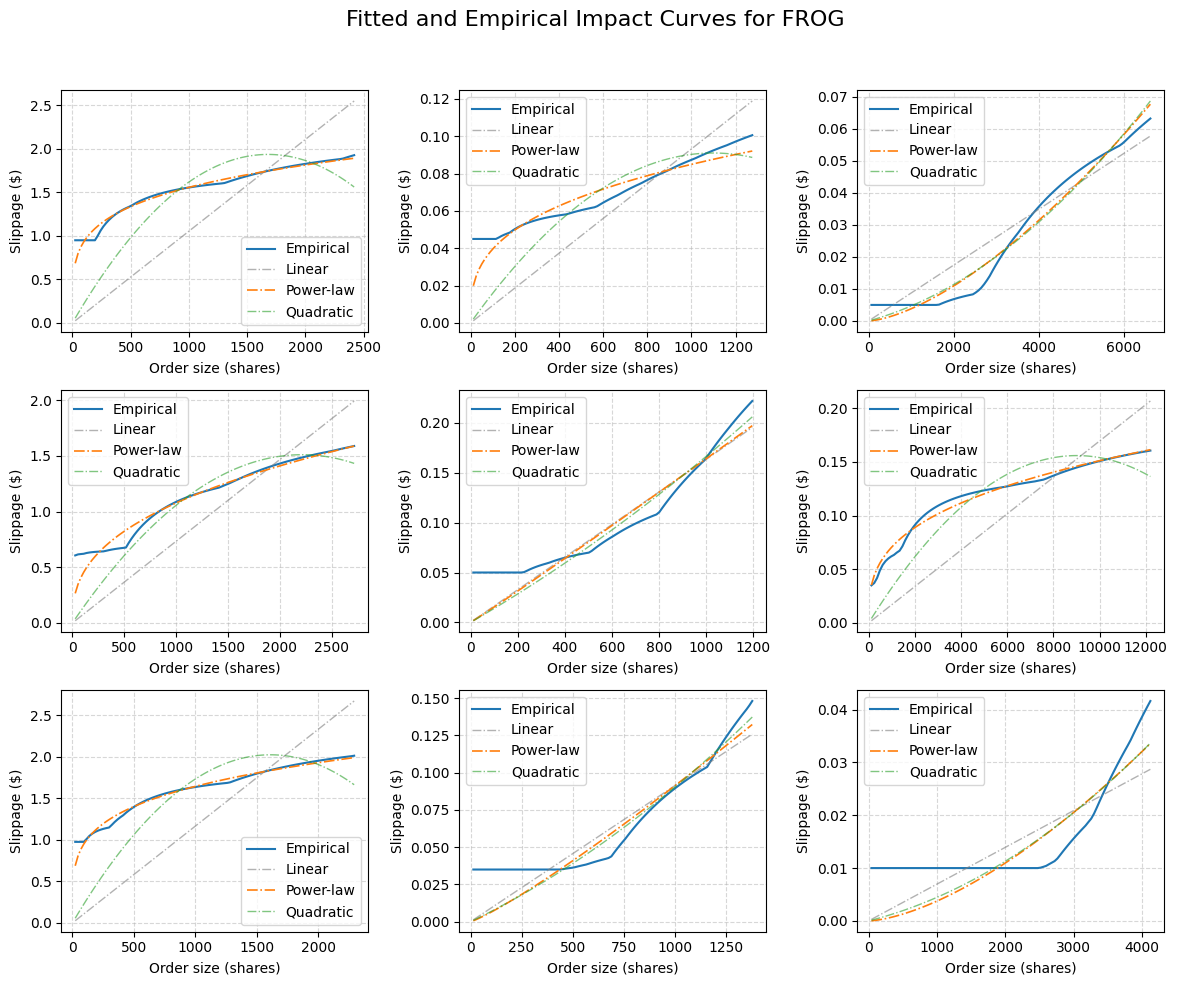

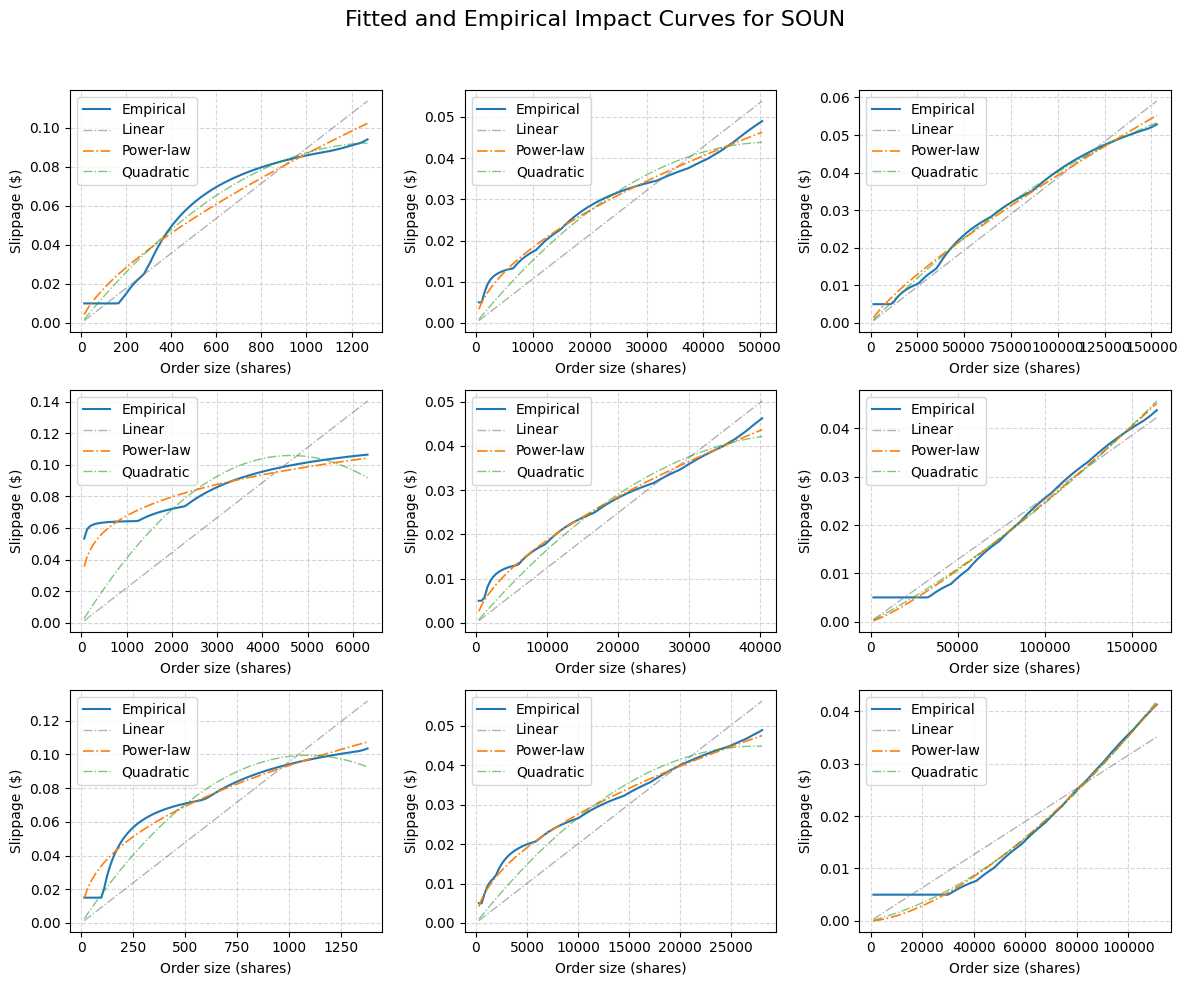

In [8]:
# Plot fitted models for each ticker
for ticker in tickers:
    df = ticker_sampled_snapshots[ticker]
    fig, axes = plt.subplots(3, 3, figsize=(12, 10))
    fig.suptitle(f"Fitted and Empirical Impact Curves for {ticker}", fontsize=16)

    for i, day in enumerate(day_indices):
        for j, offset in enumerate(time_offsets):
            row_idx = day * samples_per_day + offset

            snapshot = df.iloc[row_idx]
            x_vals, g_vals = hf.compute_empirical_impact(snapshot)
            ts = snapshot['ts_event']

            ax = axes[i][j]
            hf.plot_impact(ax, x_vals, g_vals, label='Empirical', linewidth=1.5, title=ts.strftime('%Y-%m-%d %H:%M'))
            
            # Fetch fitted params
            fit_lin = next(
                f for f in fit_results
                if f['ticker'] == ticker and f['ts_event'] == ts and f['model'] == 'linear'
            )
            g_fits_lin = hf.linear_model(x_vals, *fit_lin['params'])
            hf.plot_impact(ax, x_vals, g_fits_lin, label='Linear', linestyle='-.', alpha=0.6, color='tab:grey')

            fit_pw = next(
                f for f in fit_results
                if f['ticker'] == ticker and f['ts_event'] == ts and f['model'] == 'power_law'
            )
            g_fits_pw = hf.power_law_model(x_vals, *fit_pw['params'])
            hf.plot_impact(ax, x_vals, g_fits_pw, label='Power-law', linestyle='-.', linewidth=1.2, color='tab:orange')

            fit_quad = next(
                f for f in fit_results
                if f['ticker'] == ticker and f['ts_event'] == ts and f['model'] == 'quadratic'
            )
            g_fits_quad = hf.quadratic_model(x_vals, *fit_quad['params'])
            hf.plot_impact(ax, x_vals, g_fits_quad, label='Quadratic', linestyle='-.', alpha=0.6, color='tab:green')

            ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [9]:
# Register shifted power-law model and its initial parameters
model_configs['shifted_power_law'] = {
    'func': hf.shifted_power_law,
    'p0': None, # Will be set dynamically
    'bounds': ([0, 0, 0], [np.inf, np.inf, np.inf])
}

# Fit shifted power-law model to sampled snapshots
for ticker in tickers:
    df = ticker_sampled_snapshots[ticker]
    for row in df.itertuples():
        snapshot = df.iloc[row.Index]
        x_vals, g_vals = hf.compute_empirical_impact(snapshot)

        model_func = model_configs['shifted_power_law']['func']
        p0 = [min(g_vals), 1, 1]  # gamma, alpha, delta
        bounds = model_configs['shifted_power_law']['bounds']
        
        params, mse, r2, _ = hf.fit_impact_model(
            x_vals, g_vals,
            model_func=hf.shifted_power_law,
            p0=p0,
            bounds=bounds
        )
        fit_results.append({
            'ticker': ticker,
            'ts_event': snapshot['ts_event'],
            'model': 'shifted_power_law',
            'params': params,
            'mse': mse,
            'r2': r2
        })

In [10]:
df_fits = pd.DataFrame(fit_results)

best_by_mse = df_fits.loc[df_fits.groupby(['ticker', 'ts_event'])['mse'].idxmin()].reset_index(drop=True)
best_model_counts_mse = best_by_mse['model'].value_counts(normalize=True).reindex(model_configs.keys(), fill_value=0)
print("Model Win Rates (by MSE):")
print(best_model_counts_mse)

best_by_r2 = df_fits.loc[df_fits.groupby(['ticker', 'ts_event'])['r2'].idxmax()].reset_index(drop=True)
best_model_counts_r2 = best_by_r2['model'].value_counts(normalize=True).reindex(model_configs.keys(), fill_value=0)
print("\nModel Win Rates (by R2):")
print(best_model_counts_r2)

Model Win Rates (by MSE):
model
linear               0.000000
power_law            0.033333
quadratic            0.080952
shifted_power_law    0.885714
Name: proportion, dtype: float64

Model Win Rates (by R2):
model
linear               0.000000
power_law            0.042857
quadratic            0.080952
shifted_power_law    0.876190
Name: proportion, dtype: float64


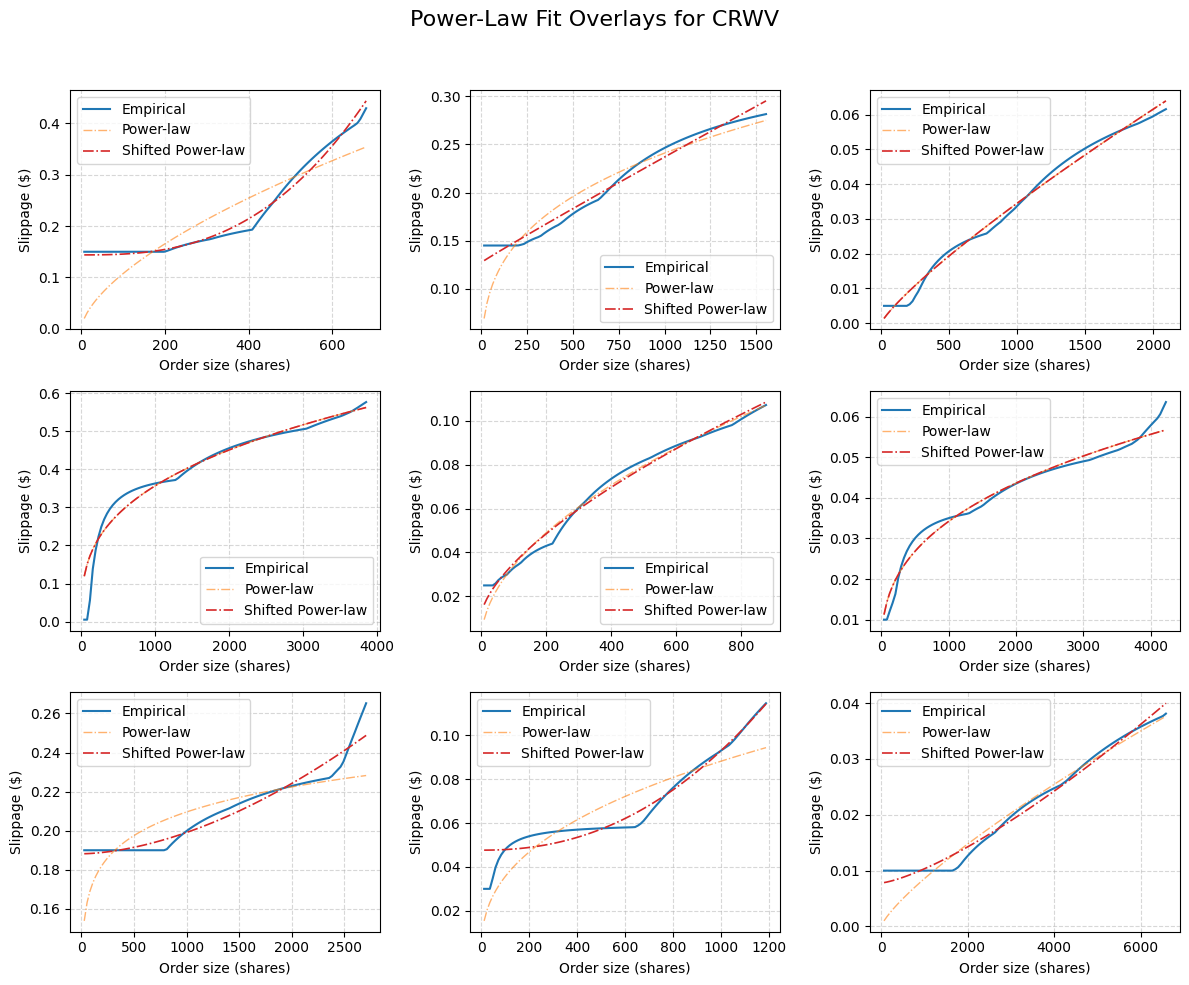

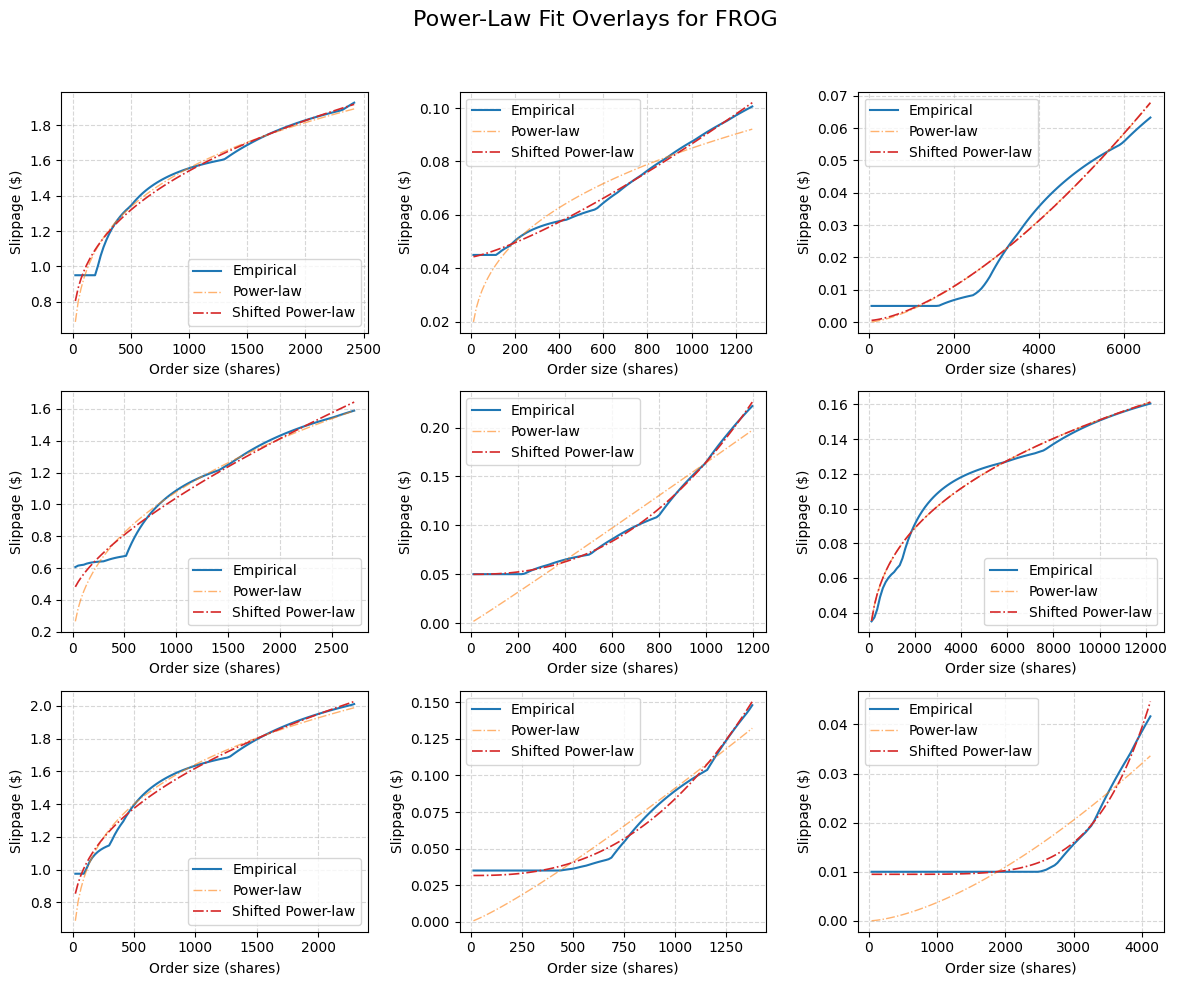

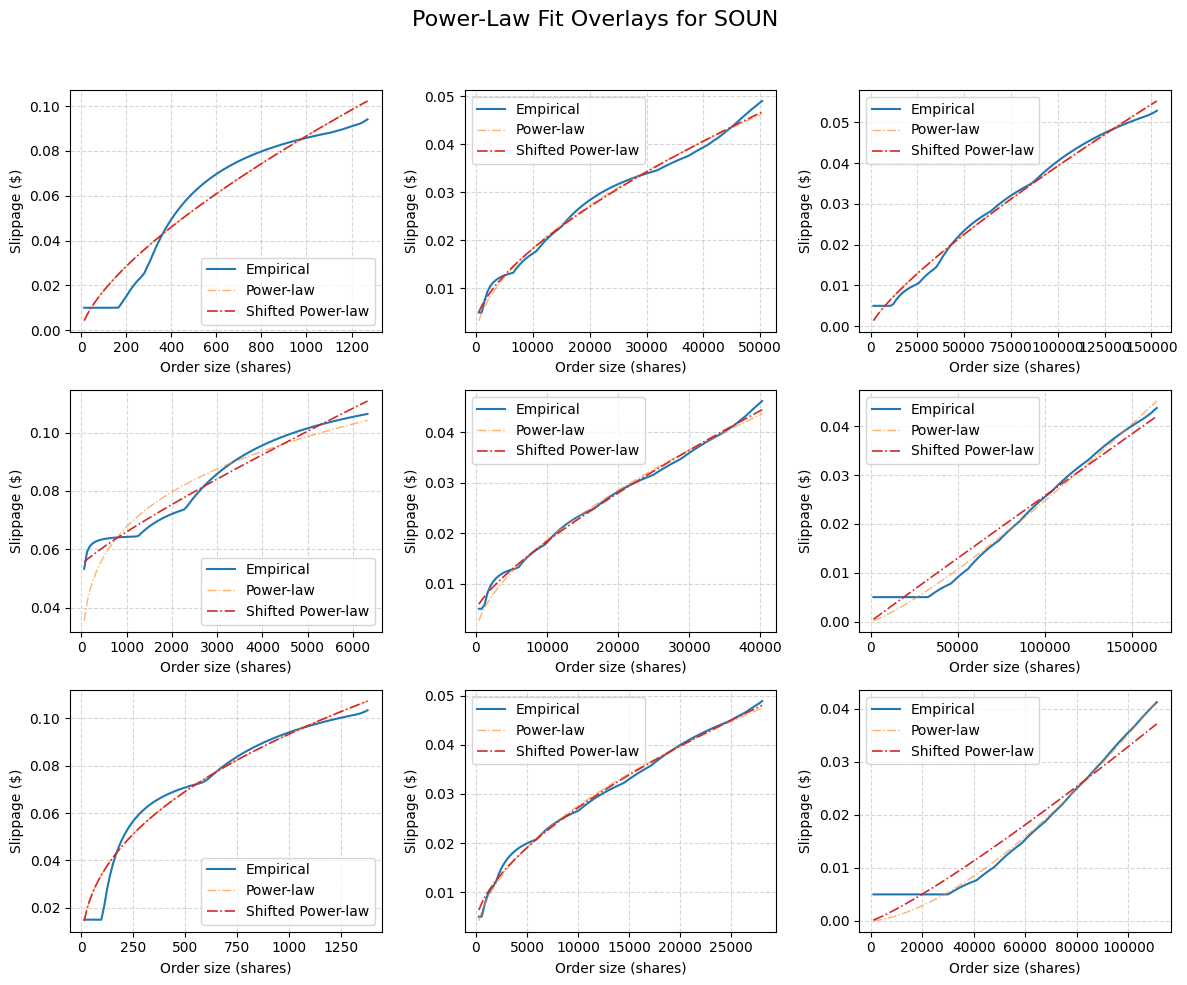

In [14]:
# Plot power-law and shifted power-law fits for each ticker
for ticker in tickers:
    df = ticker_sampled_snapshots[ticker]
    fig, axes = plt.subplots(3, 3, figsize=(12, 10))
    fig.suptitle(f"Power-Law Fit Overlays for {ticker}", fontsize=16)

    for i, day in enumerate(day_indices):
        for j, offset in enumerate(time_offsets):
            row_idx = day * samples_per_day + offset

            snapshot = df.iloc[row_idx]
            x_vals, g_vals = hf.compute_empirical_impact(snapshot)
            ts = snapshot['ts_event']

            ax = axes[i][j]
            hf.plot_impact(ax, x_vals, g_vals, label='Empirical', linewidth=1.5, title=ts.strftime('%Y-%m-%d %H:%M'))

            # Fetch fitted params
            fit_pw = next(
                f for f in fit_results
                if f['ticker'] == ticker and f['ts_event'] == ts and f['model'] == 'power_law'
            )
            g_fits_pw = hf.power_law_model(x_vals, *fit_pw['params'])
            hf.plot_impact(ax, x_vals, g_fits_pw, label='Power-law', linestyle='-.', alpha=0.6, color='tab:orange')

            fit_shifted = next(
                f for f in fit_results
                if f['ticker'] == ticker and f['ts_event'] == ts and f['model'] == 'shifted_power_law'
            )
            g_fits_shifted = hf.shifted_power_law(x_vals, *fit_shifted['params'])
            hf.plot_impact(ax, x_vals, g_fits_shifted, label='Shifted Power-law', linestyle='-.', linewidth=1.2, color='tab:red')

            ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()